# MNIST VAE demo

This notebook demonstrates the basic convolutional variational autoencoder on a dataset of rotating MNIST images.

In [1]:
import os
import csv
import sys
import torch
import gpytorch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch import optim
from torch.utils import data
from torchvision import transforms
from torch.nn import functional as F

In [2]:
# we need to manually add the project directory to the path when using Jupyter notebooks
sys.path.append("/u/14/mentus1/unix/repos/HIT_VAE")

In [3]:
from hit_vae.models import mnist_conv_vae
from hit_vae.models import losses
from hit_vae.utils import data_loading
from hit_vae.utils import plotting

In [4]:
# use the ggplot2 style in plots
plt.style.use('ggplot')

In [5]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using device: {}'.format(device))

using device: cuda


## Loading the data

In [6]:
data_base_path = '../../data/mnist_gen_flip'
# csv which contains the IDs and labels for the training data
label_path = os.path.join(data_base_path, 'labels.csv')
label_df = pd.read_csv(label_path, index_col=0)
labels = label_df.to_dict(orient='index')
# we also store all the labels in a separate list
list_IDs = list(labels.keys())

In [7]:
label_df.head()

,subject,digit,angle,sick,timestamp
0,0,3,0.242176,0,-10
1,0,3,4.613838,0,-9
2,0,3,1.580462,0,-8
3,0,3,-2.070647,0,-7
4,0,3,3.969874,0,-6


In [8]:
# for expariments use 30% of the samples for testing and validation and 70% for training
test_ratio = 0.3

# transformations applied to samples
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])

# we use the Dataset class defined in utils to store the data
training_set = data_loading.Dataset(data_base_path, list_IDs, labels, transform=transform)

n_train = len(training_set)
indices = list(labels.keys())
np.random.shuffle(indices) # we randomize the order of the samples
test_split = int(np.floor(test_ratio * n_train))
test_IDs, training_IDs = indices[:test_split], indices[test_split:]

In [9]:
# change the number of workers based on your CPU
loader_params = {'batch_size': 32, 'num_workers': 4}

training_sampler = data.SubsetRandomSampler(training_IDs)
test_sampler = data.SubsetRandomSampler(test_IDs)

# torch data loaders with parallelization for efficiency
training_loader = data.DataLoader(training_set, **loader_params, sampler=training_sampler)
test_loader = data.DataLoader(training_set, **loader_params, sampler=test_sampler)

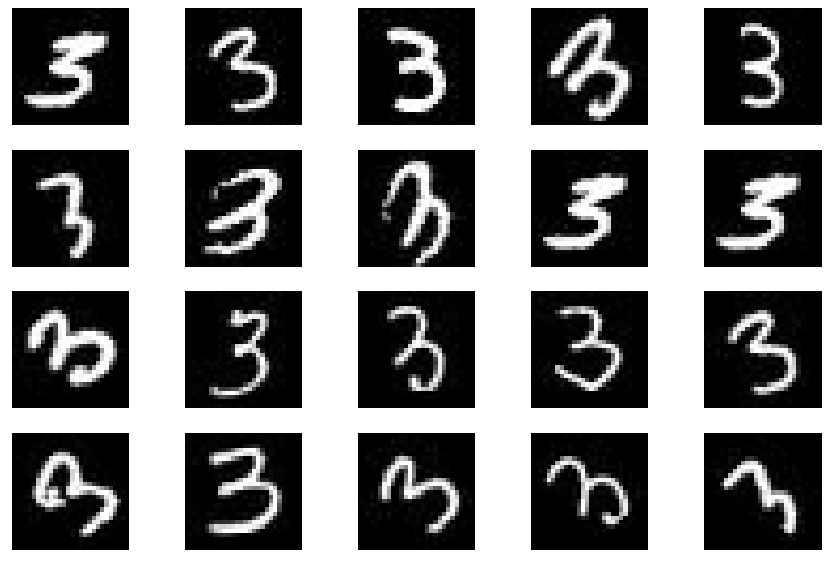

In [10]:
# visualize a set of samples as a check
images, labels = iter(training_loader).next()
plotting.visualize_samples(iter(training_loader))

## Setting up the model

In [11]:
# initialize the model defined in the models module
ldim = 1
vae_model = mnist_conv_vae.DigitVae(ldim=ldim)
vae_model.to(device)

DigitVae(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=1, bias=True)
  (fc22): Linear(in_features=32, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=784, bias=True)
  (deconv1): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [12]:
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

In [13]:
def train(epoch):
    vae_model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(training_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_model(data)
        BCE, KLD = losses.vae_loss(recon_batch, data, mu, logvar)
        loss = BCE + KLD
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(training_loader.dataset)))

In [14]:
def test(epoch):
    Z = torch.tensor([])
    Z = Z.to(device)
    
    l = {'subject': [], 'digit': [], 'angle': [], 'sick': [], 'timestamp': []}
    
    vae_model.eval()
    test_loss = 0
    test_BCE = 0
    test_KLD = 0
    
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = vae_model(data)
            #print('this is mu: {}'.format(mu))
            Z = torch.cat((Z, mu), dim=0)
            #print(len(Z))
            [l[key].extend(labels[key].numpy()) for key in l.keys()]
            
            BCE, KLD = losses.vae_loss(recon_batch, data, mu, logvar)
            test_KLD += KLD.item()
            test_BCE += BCE.item()
            test_loss += BCE.item() + KLD.item()
            if i == 0 and epoch % 10 == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch[:n]])
                img = comparison.cpu()
                #print(comparison)
                fig = plt.figure(figsize=(15, 10))
                for i in np.arange(16):
                    ax = fig.add_subplot(4, 16/4, i+1, xticks=[], yticks=[])
                    plt.imshow(img[i].view(-1, 28), cmap='gray')
                
                plt.show()
                #save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    
    test_BCE /= len(test_loader.dataset)
    test_KLD /= len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    print('====> Test set BCE: {:.4f}, KLD: {:.4f}, loss: {:.4f}'.format(test_BCE, test_KLD, test_loss))
    
    #print(data.shape)
    #print(labels.shape)
    #print(Z.shape)
    
    savepath = './results/latent_epoch_{}.png'.format(epoch)
    if epoch % 10 == 0:
        if ldim == 1:
            plotting.visualize_latent_1D(Z.cpu().numpy(), l, 'timestamp', 'subject', colormap='Set1')
        if ldim == 2:
            #vae.visualize_latent(Z.cpu().numpy(), l, 'timestamp', savepath, colormap='viridis')
            plotting.visualize_latent(Z.cpu().numpy(), l, 'digit', savepath, colormap='viridis')

====> Epoch: 1 Average loss: 334.5443
====> Test set BCE: 124.0540, KLD: 3.3375, loss: 127.3914
====> Epoch: 2 Average loss: 259.3308
====> Test set BCE: 88.4439, KLD: 2.9840, loss: 91.4279
====> Epoch: 3 Average loss: 193.9005
====> Test set BCE: 75.9135, KLD: 1.7840, loss: 77.6974
====> Epoch: 4 Average loss: 173.4966
====> Test set BCE: 71.1616, KLD: 1.3963, loss: 72.5579
====> Epoch: 5 Average loss: 166.0173
====> Test set BCE: 69.8945, KLD: 0.9072, loss: 70.8017
====> Epoch: 6 Average loss: 162.1212
====> Test set BCE: 68.4531, KLD: 0.9757, loss: 69.4288
====> Epoch: 7 Average loss: 159.5365
====> Test set BCE: 67.3319, KLD: 0.9959, loss: 68.3278
====> Epoch: 8 Average loss: 157.5459
====> Test set BCE: 67.1275, KLD: 0.8012, loss: 67.9287
====> Epoch: 9 Average loss: 156.4405
====> Test set BCE: 66.7114, KLD: 0.7639, loss: 67.4753
====> Epoch: 10 Average loss: 155.3706


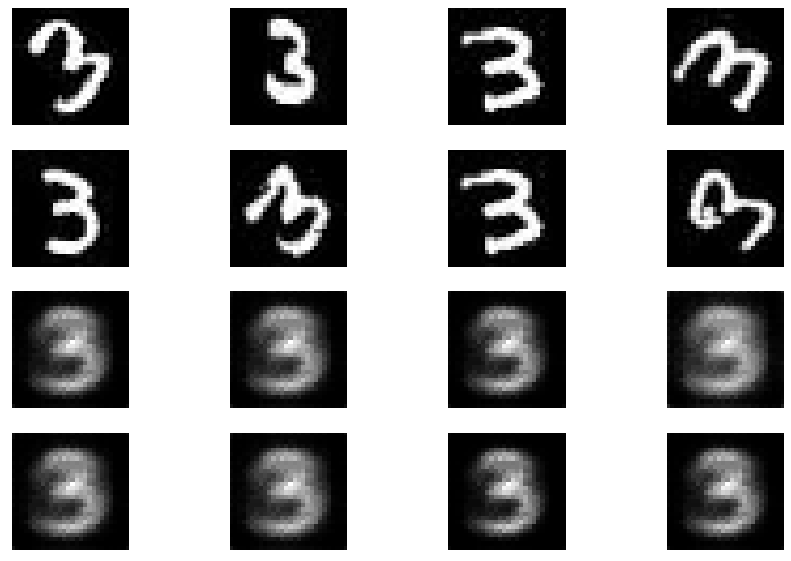

====> Test set BCE: 66.1344, KLD: 0.6560, loss: 66.7904


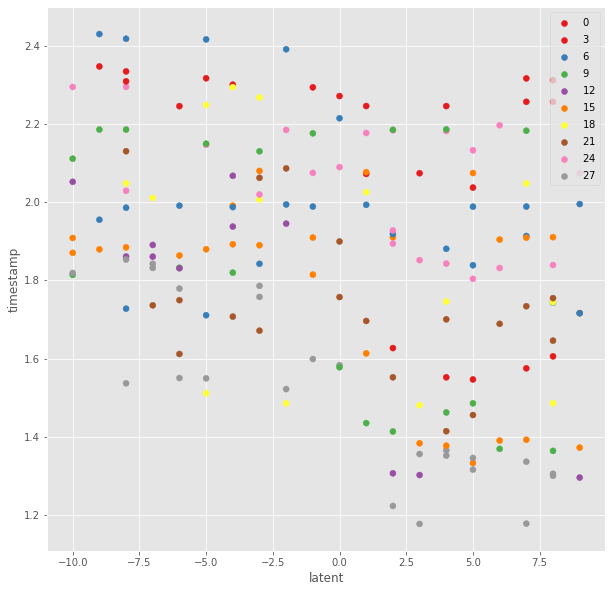

====> Epoch: 11 Average loss: 154.3599
====> Test set BCE: 65.8334, KLD: 0.6914, loss: 66.5248
====> Epoch: 12 Average loss: 153.5214
====> Test set BCE: 65.5172, KLD: 0.7034, loss: 66.2206
====> Epoch: 13 Average loss: 152.9620
====> Test set BCE: 65.2788, KLD: 0.8078, loss: 66.0866
====> Epoch: 14 Average loss: 152.4267
====> Test set BCE: 65.2087, KLD: 0.6149, loss: 65.8237
====> Epoch: 15 Average loss: 152.0361
====> Test set BCE: 64.9420, KLD: 0.6142, loss: 65.5562
====> Epoch: 16 Average loss: 151.4080
====> Test set BCE: 64.8701, KLD: 0.5669, loss: 65.4369
====> Epoch: 17 Average loss: 150.7902
====> Test set BCE: 64.6861, KLD: 0.5076, loss: 65.1937
====> Epoch: 18 Average loss: 150.4811
====> Test set BCE: 64.3788, KLD: 0.4905, loss: 64.8693
====> Epoch: 19 Average loss: 149.5992
====> Test set BCE: 63.9403, KLD: 0.5385, loss: 64.4789
====> Epoch: 20 Average loss: 148.6547


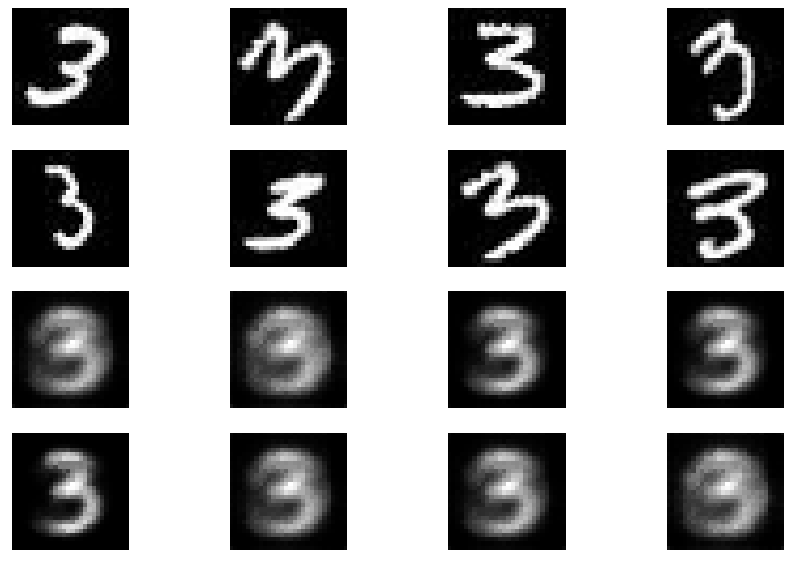

====> Test set BCE: 63.3801, KLD: 0.5549, loss: 63.9350


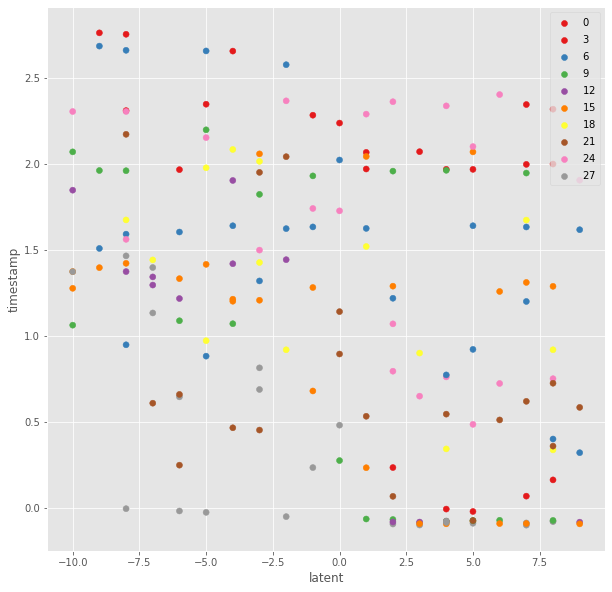

====> Epoch: 21 Average loss: 146.9266
====> Test set BCE: 62.3676, KLD: 0.5880, loss: 62.9556
====> Epoch: 22 Average loss: 144.7858
====> Test set BCE: 61.0801, KLD: 0.5990, loss: 61.6791
====> Epoch: 23 Average loss: 142.4105
====> Test set BCE: 60.0040, KLD: 0.7912, loss: 60.7951
====> Epoch: 24 Average loss: 141.1354
====> Test set BCE: 59.6713, KLD: 0.5961, loss: 60.2674
====> Epoch: 25 Average loss: 139.6035
====> Test set BCE: 59.3835, KLD: 0.5563, loss: 59.9398
====> Epoch: 26 Average loss: 139.0170
====> Test set BCE: 58.9119, KLD: 0.6386, loss: 59.5505
====> Epoch: 27 Average loss: 138.2488
====> Test set BCE: 58.6107, KLD: 0.6614, loss: 59.2721
====> Epoch: 28 Average loss: 137.5079
====> Test set BCE: 58.4291, KLD: 0.6029, loss: 59.0320
====> Epoch: 29 Average loss: 137.0676
====> Test set BCE: 58.2747, KLD: 0.6381, loss: 58.9128
====> Epoch: 30 Average loss: 136.4786


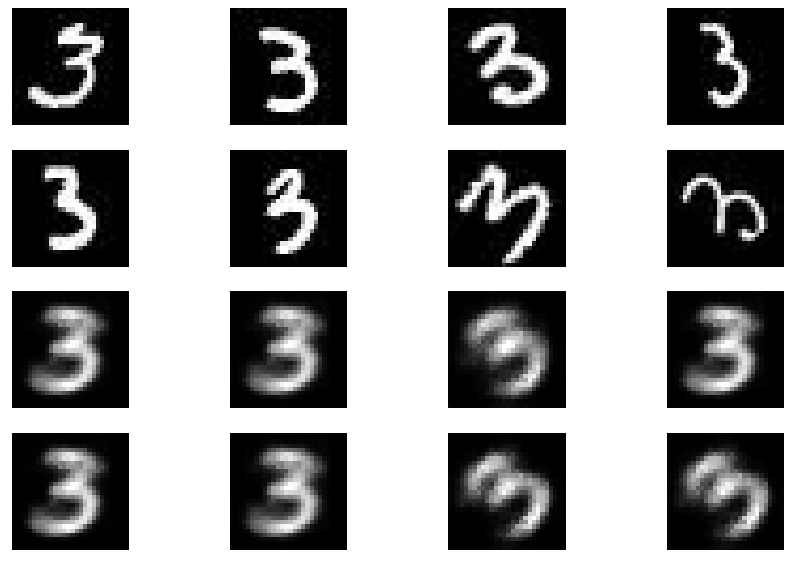

====> Test set BCE: 58.0356, KLD: 0.6118, loss: 58.6474


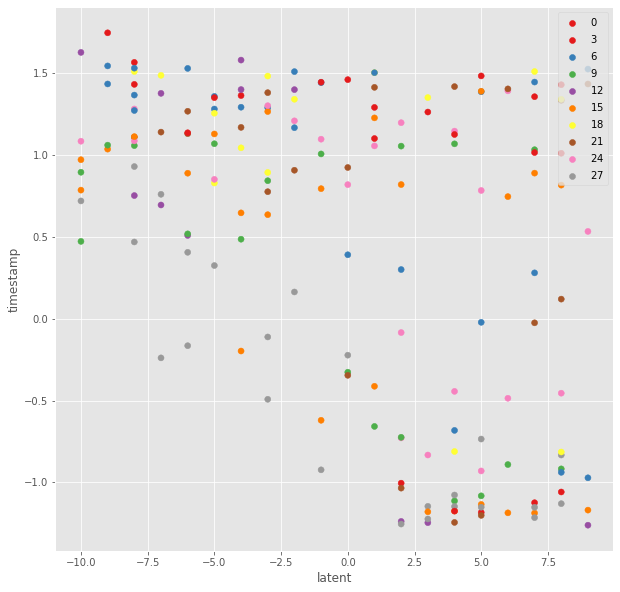

====> Epoch: 31 Average loss: 136.1065
====> Test set BCE: 57.8253, KLD: 0.6344, loss: 58.4597
====> Epoch: 32 Average loss: 135.2412
====> Test set BCE: 57.6399, KLD: 0.6322, loss: 58.2721
====> Epoch: 33 Average loss: 134.7280
====> Test set BCE: 57.3385, KLD: 0.6394, loss: 57.9779
====> Epoch: 34 Average loss: 134.2434
====> Test set BCE: 57.0867, KLD: 0.6334, loss: 57.7201
====> Epoch: 35 Average loss: 133.4647
====> Test set BCE: 56.9477, KLD: 0.6404, loss: 57.5881
====> Epoch: 36 Average loss: 133.2926
====> Test set BCE: 56.7083, KLD: 0.6803, loss: 57.3886
====> Epoch: 37 Average loss: 132.7956
====> Test set BCE: 56.4002, KLD: 0.6755, loss: 57.0757
====> Epoch: 38 Average loss: 132.1952
====> Test set BCE: 56.2573, KLD: 0.7091, loss: 56.9664
====> Epoch: 39 Average loss: 131.8805
====> Test set BCE: 56.0475, KLD: 0.7297, loss: 56.7772
====> Epoch: 40 Average loss: 131.4357


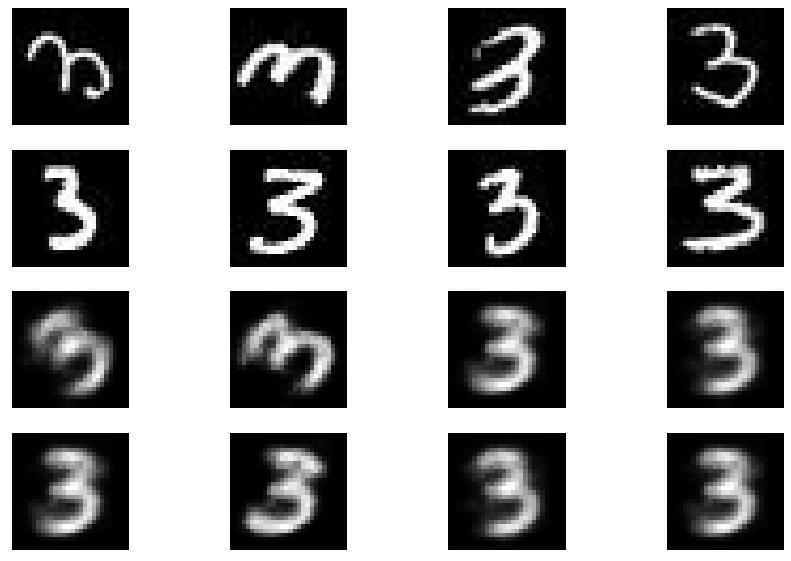

====> Test set BCE: 56.0651, KLD: 0.7191, loss: 56.7842


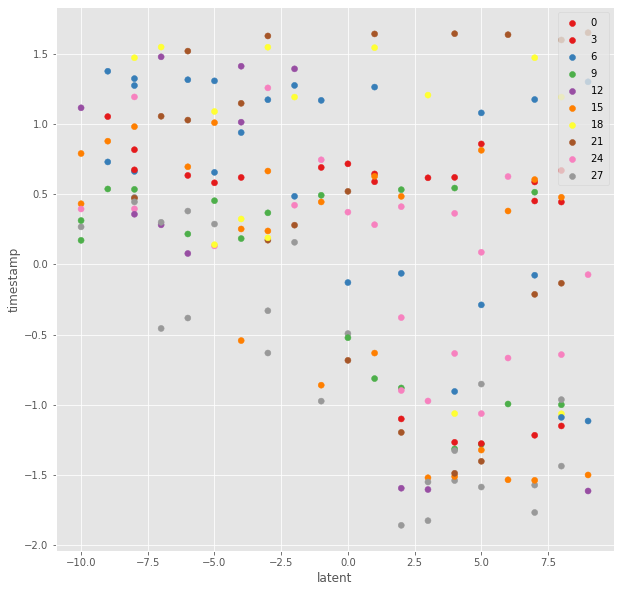

====> Epoch: 41 Average loss: 131.1185
====> Test set BCE: 55.9303, KLD: 0.7033, loss: 56.6336
====> Epoch: 42 Average loss: 130.9329
====> Test set BCE: 55.8720, KLD: 0.7204, loss: 56.5924
====> Epoch: 43 Average loss: 130.5297
====> Test set BCE: 55.6528, KLD: 0.7241, loss: 56.3769
====> Epoch: 44 Average loss: 130.3104
====> Test set BCE: 55.6666, KLD: 0.7417, loss: 56.4083
====> Epoch: 45 Average loss: 130.1917
====> Test set BCE: 55.5007, KLD: 0.7018, loss: 56.2025
====> Epoch: 46 Average loss: 129.9016
====> Test set BCE: 55.3079, KLD: 0.7217, loss: 56.0296
====> Epoch: 47 Average loss: 129.5657
====> Test set BCE: 55.2065, KLD: 0.7255, loss: 55.9321
====> Epoch: 48 Average loss: 129.3908
====> Test set BCE: 55.1671, KLD: 0.7518, loss: 55.9190
====> Epoch: 49 Average loss: 129.2447
====> Test set BCE: 55.0806, KLD: 0.7522, loss: 55.8328
====> Epoch: 50 Average loss: 129.1540


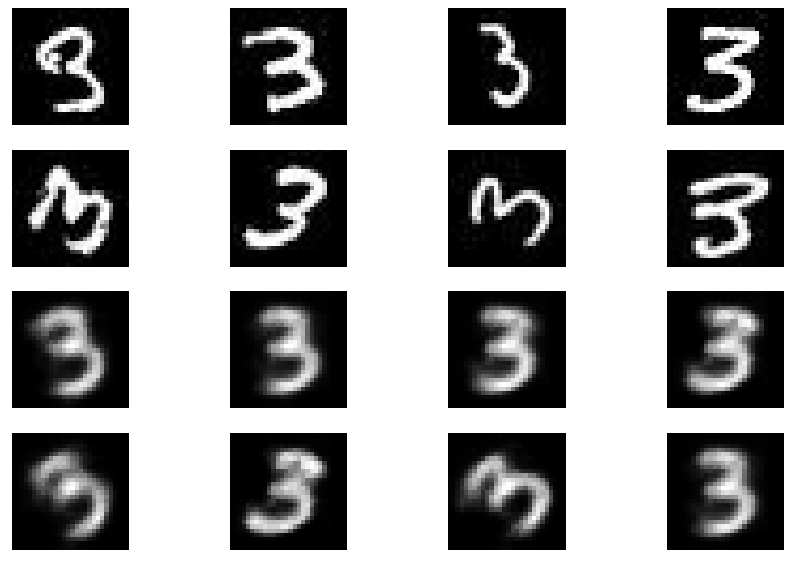

====> Test set BCE: 55.3937, KLD: 0.7395, loss: 56.1333


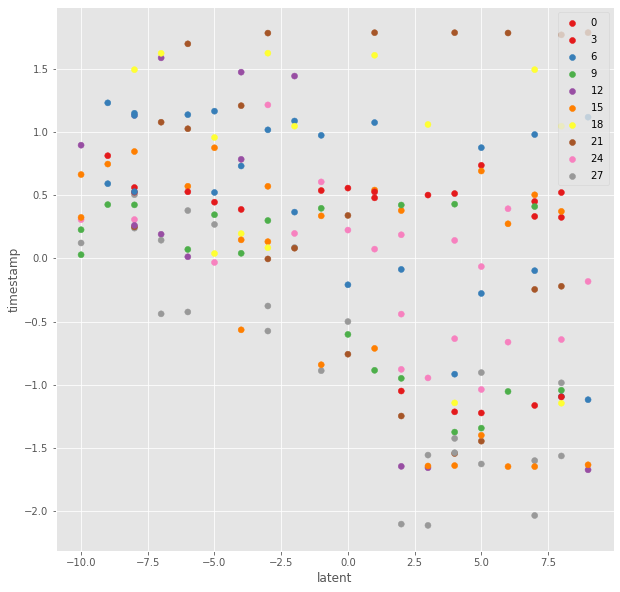

====> Epoch: 51 Average loss: 129.1617
====> Test set BCE: 54.9904, KLD: 0.7252, loss: 55.7156
====> Epoch: 52 Average loss: 128.7824
====> Test set BCE: 54.8634, KLD: 0.7198, loss: 55.5832
====> Epoch: 53 Average loss: 128.7805
====> Test set BCE: 54.9029, KLD: 0.7572, loss: 55.6600
====> Epoch: 54 Average loss: 128.7184
====> Test set BCE: 54.9674, KLD: 0.7559, loss: 55.7233
====> Epoch: 55 Average loss: 128.4417
====> Test set BCE: 54.7702, KLD: 0.7266, loss: 55.4968
====> Epoch: 56 Average loss: 128.3252
====> Test set BCE: 54.7559, KLD: 0.7241, loss: 55.4800
====> Epoch: 57 Average loss: 128.2698
====> Test set BCE: 54.8117, KLD: 0.7757, loss: 55.5875
====> Epoch: 58 Average loss: 127.9575
====> Test set BCE: 54.8099, KLD: 0.7646, loss: 55.5745
====> Epoch: 59 Average loss: 128.0235
====> Test set BCE: 55.1350, KLD: 0.7388, loss: 55.8738
====> Epoch: 60 Average loss: 128.3821


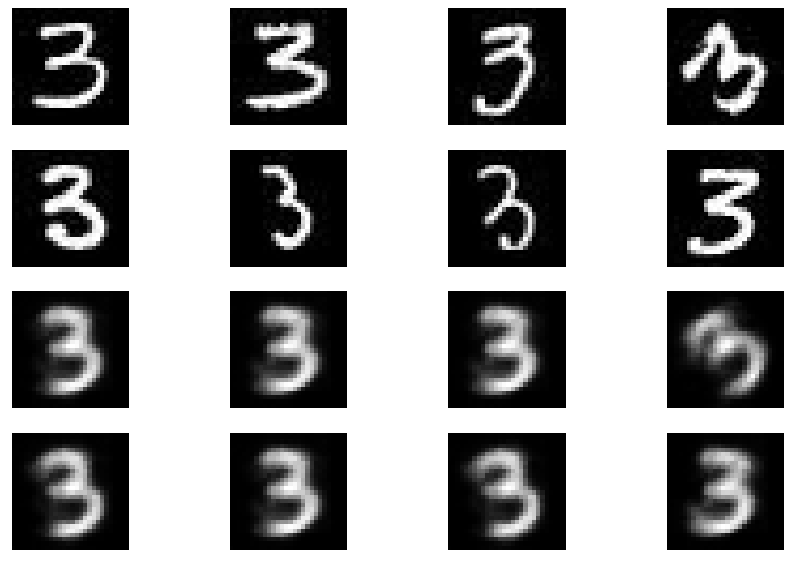

====> Test set BCE: 54.6598, KLD: 0.7446, loss: 55.4045


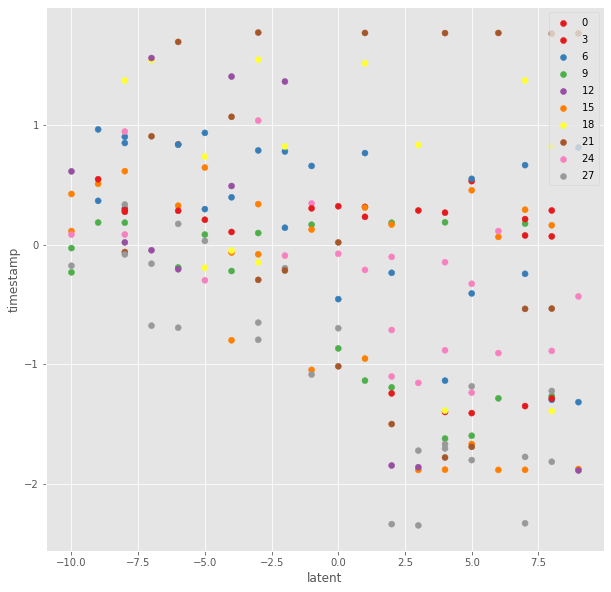

====> Epoch: 61 Average loss: 127.6372
====> Test set BCE: 54.4609, KLD: 0.7610, loss: 55.2218
====> Epoch: 62 Average loss: 127.5758
====> Test set BCE: 54.5962, KLD: 0.7676, loss: 55.3638
====> Epoch: 63 Average loss: 127.8483
====> Test set BCE: 54.5298, KLD: 0.7429, loss: 55.2727
====> Epoch: 64 Average loss: 127.7126
====> Test set BCE: 54.4791, KLD: 0.7360, loss: 55.2151
====> Epoch: 65 Average loss: 127.5045
====> Test set BCE: 55.0405, KLD: 0.7995, loss: 55.8400
====> Epoch: 66 Average loss: 128.3514
====> Test set BCE: 54.7514, KLD: 0.7274, loss: 55.4787
====> Epoch: 67 Average loss: 128.0581
====> Test set BCE: 54.5978, KLD: 0.7465, loss: 55.3442
====> Epoch: 68 Average loss: 127.4752
====> Test set BCE: 54.3853, KLD: 0.7812, loss: 55.1665
====> Epoch: 69 Average loss: 127.1878
====> Test set BCE: 54.3138, KLD: 0.7568, loss: 55.0706
====> Epoch: 70 Average loss: 126.8682


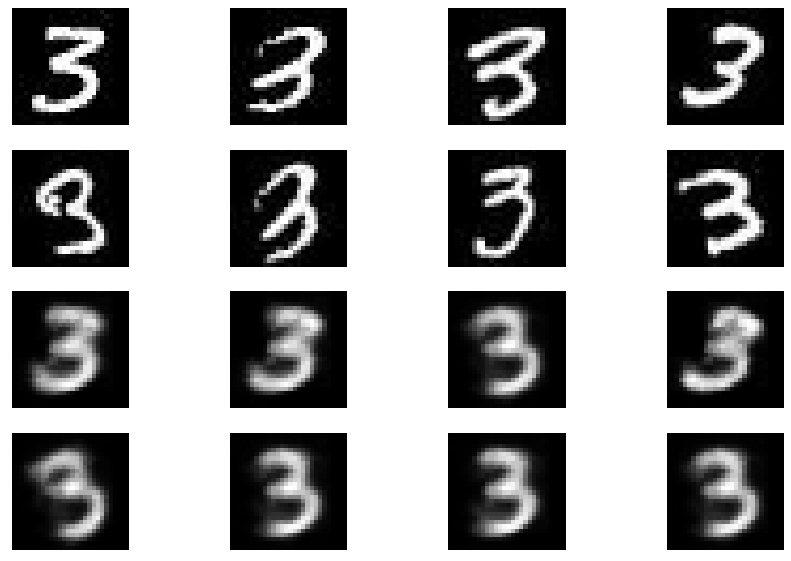

====> Test set BCE: 54.2310, KLD: 0.7566, loss: 54.9875


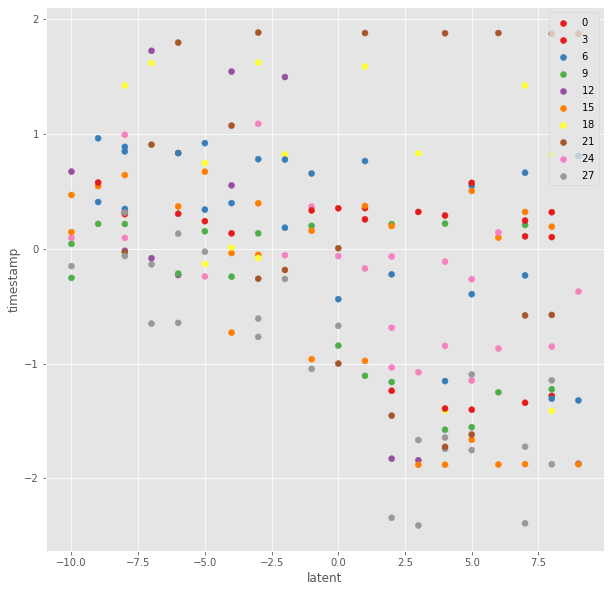

====> Epoch: 71 Average loss: 126.6815
====> Test set BCE: 54.4468, KLD: 0.7554, loss: 55.2022
====> Epoch: 72 Average loss: 126.9329
====> Test set BCE: 54.1650, KLD: 0.7910, loss: 54.9560
====> Epoch: 73 Average loss: 126.8091
====> Test set BCE: 54.1468, KLD: 0.8102, loss: 54.9570
====> Epoch: 74 Average loss: 126.7305
====> Test set BCE: 54.1219, KLD: 0.7954, loss: 54.9173
====> Epoch: 75 Average loss: 126.5244
====> Test set BCE: 54.0679, KLD: 0.7894, loss: 54.8573
====> Epoch: 76 Average loss: 126.3768
====> Test set BCE: 54.0353, KLD: 0.7725, loss: 54.8078
====> Epoch: 77 Average loss: 126.3362
====> Test set BCE: 54.1749, KLD: 0.7932, loss: 54.9682
====> Epoch: 78 Average loss: 126.2517
====> Test set BCE: 54.0096, KLD: 0.7902, loss: 54.7999
====> Epoch: 79 Average loss: 126.2019
====> Test set BCE: 54.0174, KLD: 0.8036, loss: 54.8209
====> Epoch: 80 Average loss: 126.1283


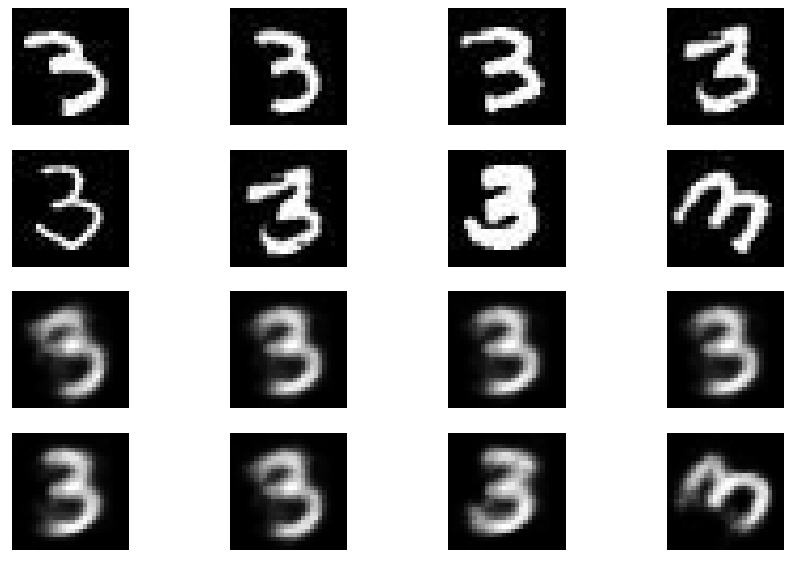

====> Test set BCE: 54.0822, KLD: 0.8072, loss: 54.8894


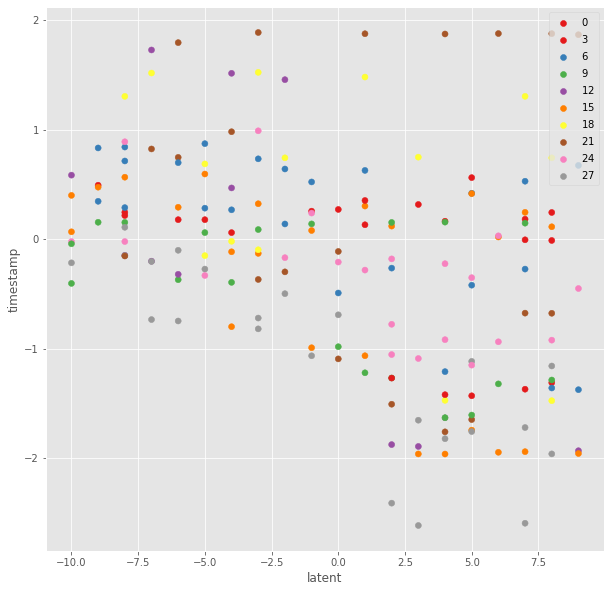

====> Epoch: 81 Average loss: 126.1838
====> Test set BCE: 53.9743, KLD: 0.7758, loss: 54.7502
====> Epoch: 82 Average loss: 125.9931
====> Test set BCE: 54.0357, KLD: 0.7870, loss: 54.8228
====> Epoch: 83 Average loss: 125.9241
====> Test set BCE: 54.0964, KLD: 0.7735, loss: 54.8699
====> Epoch: 84 Average loss: 126.1730
====> Test set BCE: 53.9546, KLD: 0.7821, loss: 54.7367
====> Epoch: 85 Average loss: 125.7115
====> Test set BCE: 53.8390, KLD: 0.7946, loss: 54.6335
====> Epoch: 86 Average loss: 125.6251
====> Test set BCE: 54.1298, KLD: 0.8032, loss: 54.9330
====> Epoch: 87 Average loss: 126.0473
====> Test set BCE: 55.0085, KLD: 0.7603, loss: 55.7688
====> Epoch: 88 Average loss: 126.4918
====> Test set BCE: 54.3512, KLD: 0.7052, loss: 55.0564
====> Epoch: 89 Average loss: 126.3312
====> Test set BCE: 54.0607, KLD: 0.7889, loss: 54.8497
====> Epoch: 90 Average loss: 125.7400


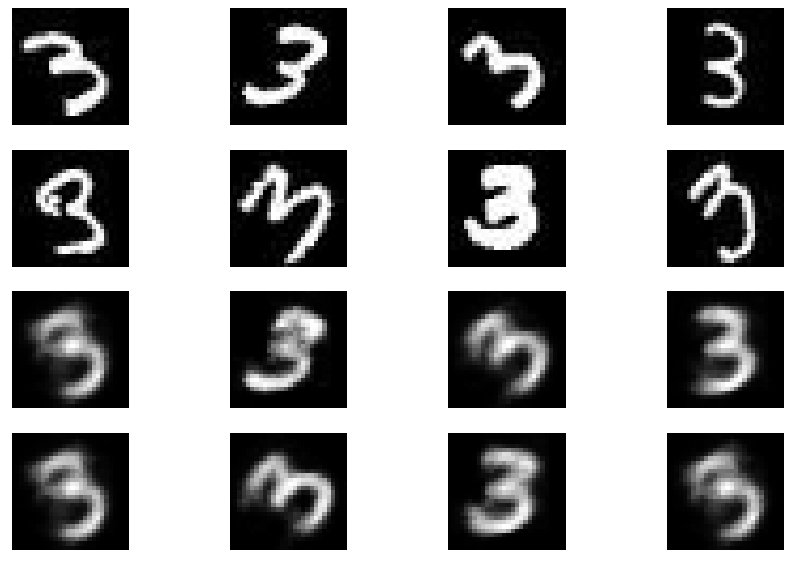

====> Test set BCE: 53.8157, KLD: 0.8405, loss: 54.6562


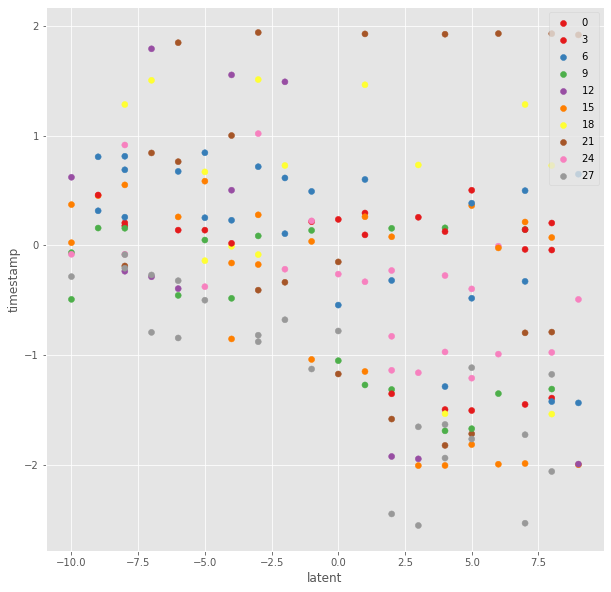

====> Epoch: 91 Average loss: 125.4673
====> Test set BCE: 53.7893, KLD: 0.8088, loss: 54.5981
====> Epoch: 92 Average loss: 125.4043
====> Test set BCE: 53.7599, KLD: 0.8121, loss: 54.5721
====> Epoch: 93 Average loss: 125.1691
====> Test set BCE: 53.7283, KLD: 0.8043, loss: 54.5326
====> Epoch: 94 Average loss: 125.2062
====> Test set BCE: 53.6693, KLD: 0.7697, loss: 54.4390
====> Epoch: 95 Average loss: 125.1067
====> Test set BCE: 53.7397, KLD: 0.8156, loss: 54.5553
====> Epoch: 96 Average loss: 125.2222
====> Test set BCE: 53.6440, KLD: 0.8176, loss: 54.4616
====> Epoch: 97 Average loss: 125.1251
====> Test set BCE: 53.7009, KLD: 0.8387, loss: 54.5396
====> Epoch: 98 Average loss: 125.0320
====> Test set BCE: 53.6705, KLD: 0.8353, loss: 54.5058
====> Epoch: 99 Average loss: 124.8595
====> Test set BCE: 53.5654, KLD: 0.8126, loss: 54.3780
====> Epoch: 100 Average loss: 124.6493


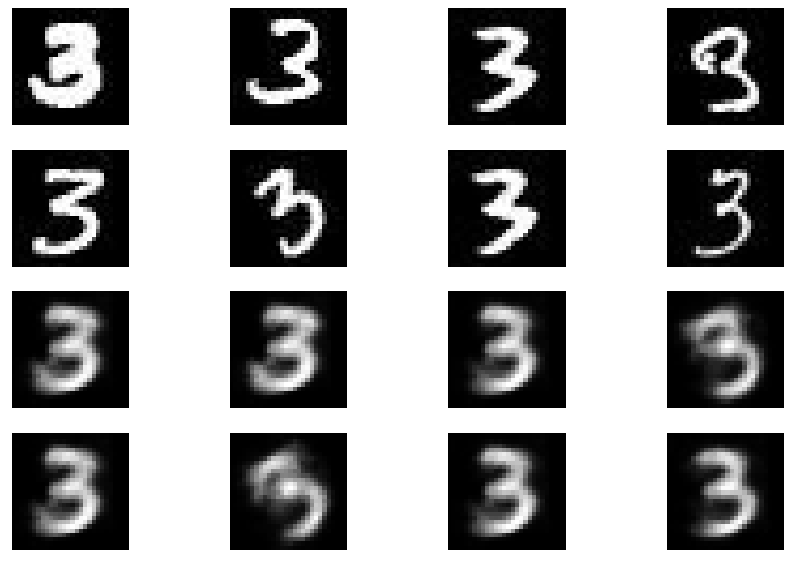

====> Test set BCE: 53.5864, KLD: 0.8363, loss: 54.4228


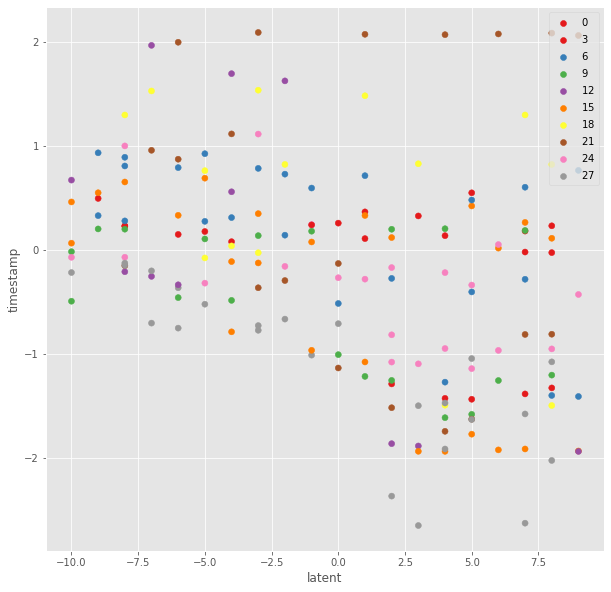

====> Epoch: 101 Average loss: 124.6917
====> Test set BCE: 53.4161, KLD: 0.8491, loss: 54.2653
====> Epoch: 102 Average loss: 124.6468
====> Test set BCE: 53.4056, KLD: 0.8712, loss: 54.2768
====> Epoch: 103 Average loss: 124.5809
====> Test set BCE: 53.9264, KLD: 0.8247, loss: 54.7511
====> Epoch: 104 Average loss: 124.5763
====> Test set BCE: 53.6201, KLD: 0.8168, loss: 54.4369
====> Epoch: 105 Average loss: 124.5449
====> Test set BCE: 53.6482, KLD: 0.8532, loss: 54.5013
====> Epoch: 106 Average loss: 124.4841
====> Test set BCE: 53.9453, KLD: 0.8552, loss: 54.8005
====> Epoch: 107 Average loss: 124.9484
====> Test set BCE: 53.3338, KLD: 0.7945, loss: 54.1283
====> Epoch: 108 Average loss: 124.3323
====> Test set BCE: 53.4236, KLD: 0.8095, loss: 54.2331
====> Epoch: 109 Average loss: 124.1449
====> Test set BCE: 53.4058, KLD: 0.8615, loss: 54.2673
====> Epoch: 110 Average loss: 123.9985


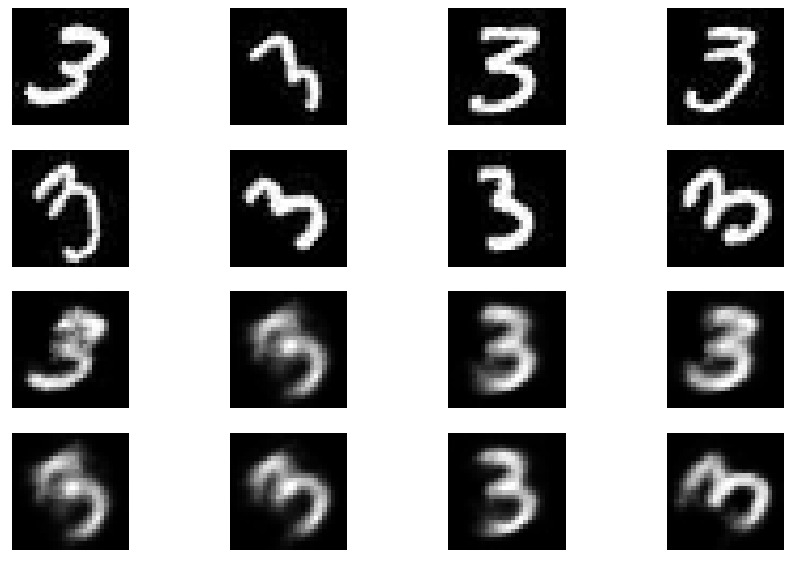

====> Test set BCE: 53.8724, KLD: 0.8632, loss: 54.7356


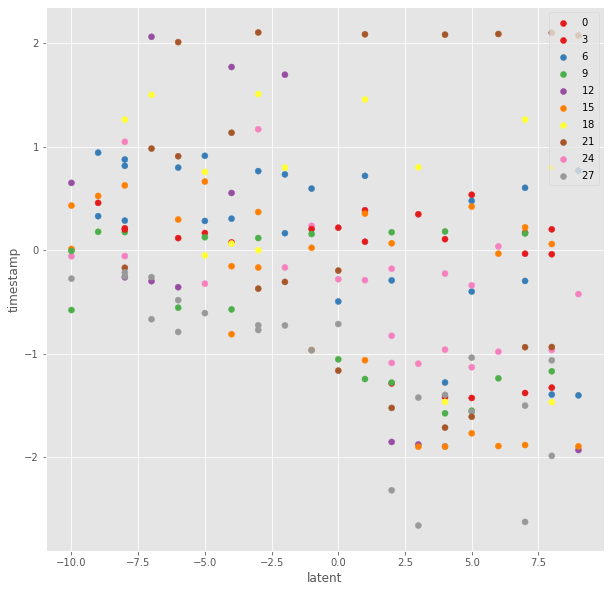

====> Epoch: 111 Average loss: 124.1789
====> Test set BCE: 53.3452, KLD: 0.8816, loss: 54.2268
====> Epoch: 112 Average loss: 124.2086
====> Test set BCE: 53.7657, KLD: 0.8350, loss: 54.6007
====> Epoch: 113 Average loss: 123.9770
====> Test set BCE: 53.1691, KLD: 0.8490, loss: 54.0182
====> Epoch: 114 Average loss: 123.6792
====> Test set BCE: 53.2844, KLD: 0.8574, loss: 54.1418
====> Epoch: 115 Average loss: 123.9359
====> Test set BCE: 53.1837, KLD: 0.8727, loss: 54.0564
====> Epoch: 116 Average loss: 123.8435
====> Test set BCE: 53.4161, KLD: 0.8783, loss: 54.2944
====> Epoch: 117 Average loss: 123.9791
====> Test set BCE: 53.6289, KLD: 0.8413, loss: 54.4702
====> Epoch: 118 Average loss: 123.8951
====> Test set BCE: 53.1179, KLD: 0.8765, loss: 53.9944
====> Epoch: 119 Average loss: 123.6138
====> Test set BCE: 53.2910, KLD: 0.8741, loss: 54.1651
====> Epoch: 120 Average loss: 123.3762


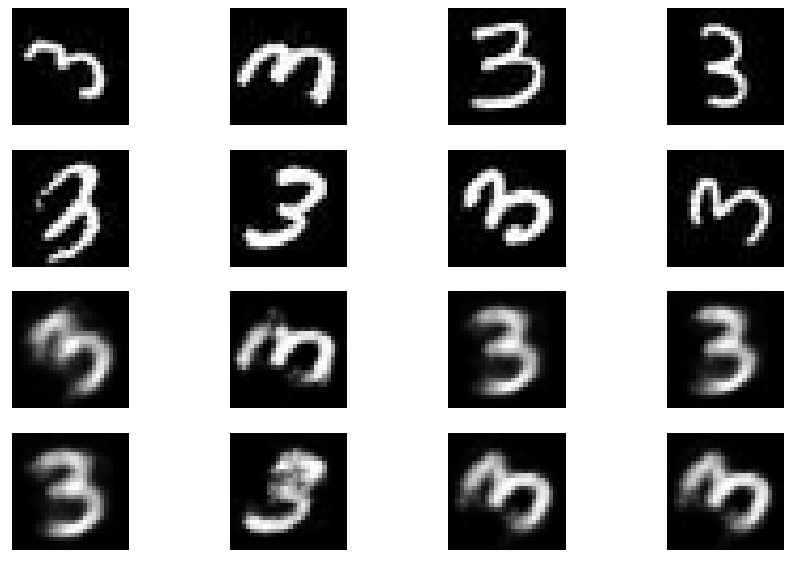

====> Test set BCE: 53.0720, KLD: 0.8391, loss: 53.9111


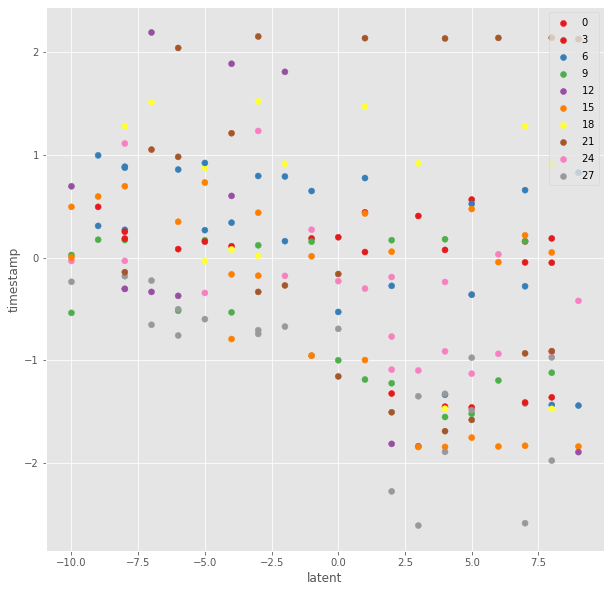

====> Epoch: 121 Average loss: 123.4049
====> Test set BCE: 53.0513, KLD: 0.8714, loss: 53.9226
====> Epoch: 122 Average loss: 123.2087
====> Test set BCE: 53.1732, KLD: 0.8875, loss: 54.0607
====> Epoch: 123 Average loss: 123.8629
====> Test set BCE: 53.2898, KLD: 0.8739, loss: 54.1637
====> Epoch: 124 Average loss: 123.4671
====> Test set BCE: 52.9744, KLD: 0.8905, loss: 53.8649
====> Epoch: 125 Average loss: 123.0278
====> Test set BCE: 53.0284, KLD: 0.8619, loss: 53.8902
====> Epoch: 126 Average loss: 122.9971
====> Test set BCE: 52.9808, KLD: 0.9062, loss: 53.8871
====> Epoch: 127 Average loss: 122.8432
====> Test set BCE: 53.0955, KLD: 0.8544, loss: 53.9499
====> Epoch: 128 Average loss: 122.8275
====> Test set BCE: 53.1502, KLD: 0.8788, loss: 54.0290
====> Epoch: 129 Average loss: 123.1897
====> Test set BCE: 53.5225, KLD: 0.8482, loss: 54.3707
====> Epoch: 130 Average loss: 123.4184


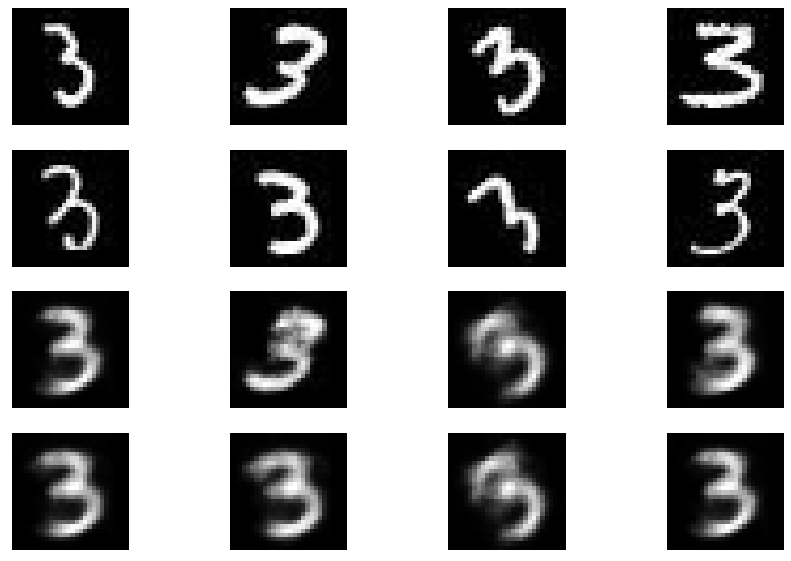

====> Test set BCE: 53.7046, KLD: 0.8449, loss: 54.5495


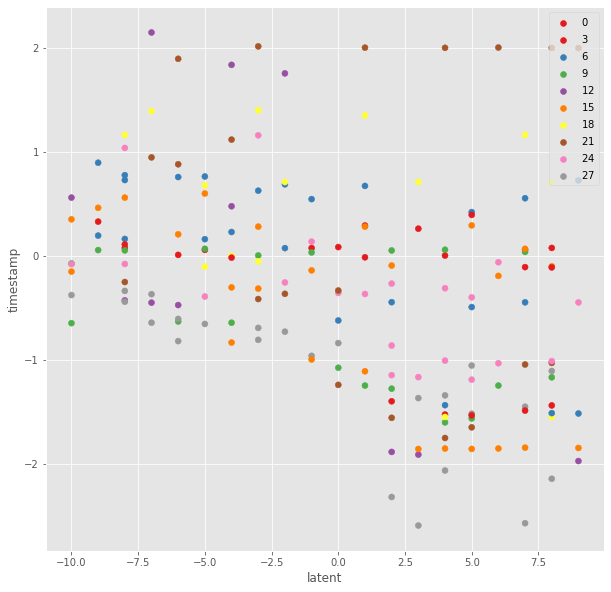

====> Epoch: 131 Average loss: 123.4302
====> Test set BCE: 53.1049, KLD: 0.8632, loss: 53.9681
====> Epoch: 132 Average loss: 123.2456
====> Test set BCE: 53.2325, KLD: 0.8439, loss: 54.0764
====> Epoch: 133 Average loss: 122.9512
====> Test set BCE: 53.0822, KLD: 0.8809, loss: 53.9632
====> Epoch: 134 Average loss: 122.5923
====> Test set BCE: 53.1189, KLD: 0.8698, loss: 53.9887
====> Epoch: 135 Average loss: 122.2589
====> Test set BCE: 53.1706, KLD: 0.8969, loss: 54.0675
====> Epoch: 136 Average loss: 122.7534
====> Test set BCE: 53.3615, KLD: 0.8604, loss: 54.2219
====> Epoch: 137 Average loss: 122.8052
====> Test set BCE: 52.8199, KLD: 0.8884, loss: 53.7083
====> Epoch: 138 Average loss: 122.3610
====> Test set BCE: 52.7149, KLD: 0.9507, loss: 53.6656
====> Epoch: 139 Average loss: 122.0483
====> Test set BCE: 52.9158, KLD: 0.8596, loss: 53.7754
====> Epoch: 140 Average loss: 122.2332


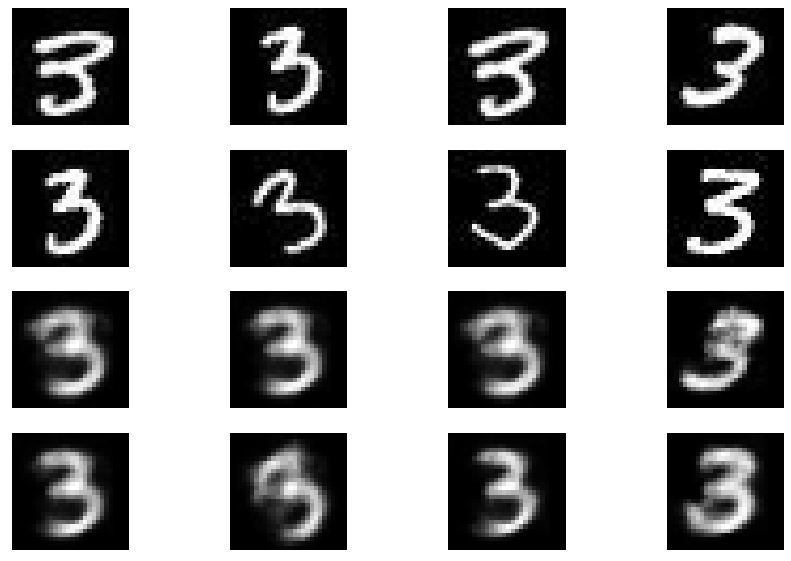

====> Test set BCE: 52.6279, KLD: 0.8974, loss: 53.5253


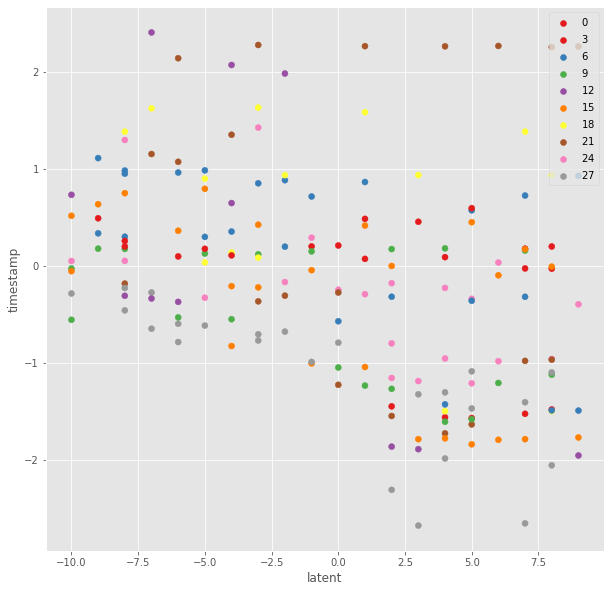

====> Epoch: 141 Average loss: 122.0300
====> Test set BCE: 52.8551, KLD: 0.9357, loss: 53.7908
====> Epoch: 142 Average loss: 121.8888
====> Test set BCE: 53.0122, KLD: 0.8928, loss: 53.9049
====> Epoch: 143 Average loss: 122.1155
====> Test set BCE: 53.2621, KLD: 0.9243, loss: 54.1864
====> Epoch: 144 Average loss: 122.1316
====> Test set BCE: 53.0659, KLD: 0.9031, loss: 53.9691
====> Epoch: 145 Average loss: 122.8700
====> Test set BCE: 53.1281, KLD: 0.8778, loss: 54.0059
====> Epoch: 146 Average loss: 122.2406
====> Test set BCE: 52.6063, KLD: 0.9535, loss: 53.5598
====> Epoch: 147 Average loss: 121.7361
====> Test set BCE: 53.0221, KLD: 0.9350, loss: 53.9570
====> Epoch: 148 Average loss: 121.6338
====> Test set BCE: 52.5562, KLD: 0.9239, loss: 53.4801
====> Epoch: 149 Average loss: 121.5234
====> Test set BCE: 52.4381, KLD: 0.9471, loss: 53.3852
====> Epoch: 150 Average loss: 121.3105


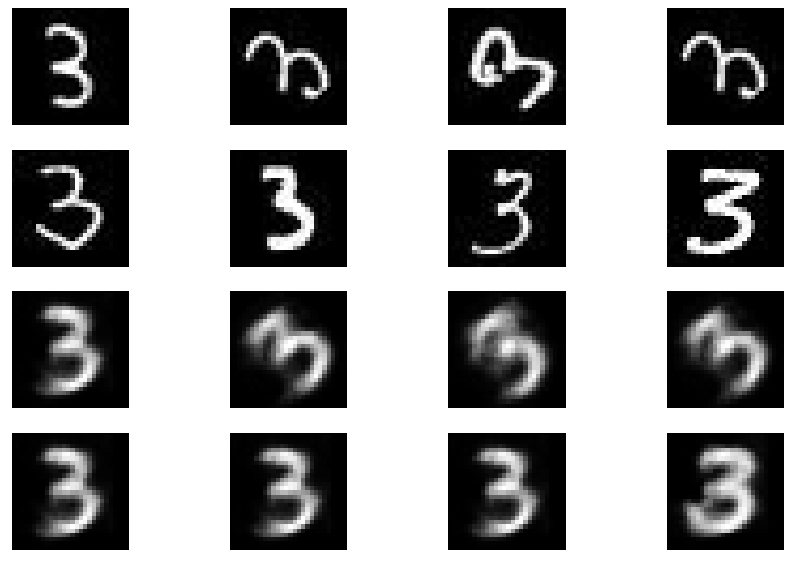

====> Test set BCE: 52.5490, KLD: 0.9301, loss: 53.4791


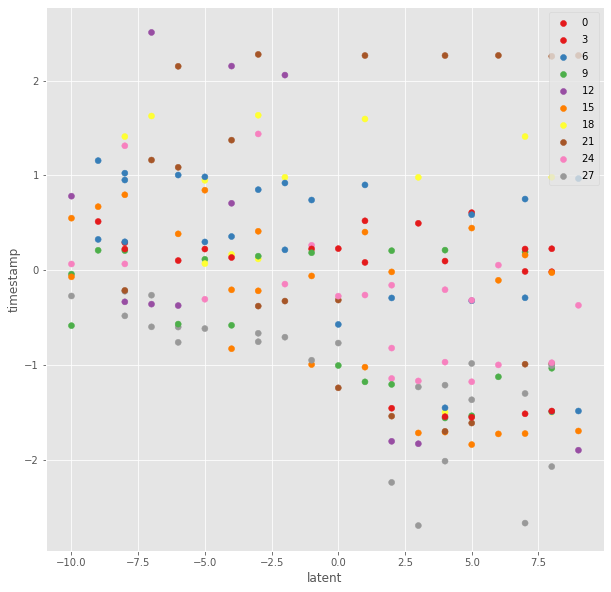

In [15]:
epochs = 150

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    
    with torch.no_grad():
        sample = torch.randn(64, ldim).to(device)
        sample = vae_model.decode(sample).cpu()
        #save_image(sample.view(64, 1, 28, 28),
        #           'results/sample_' + str(epoch) + '.png')